# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 марта 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 марта, -4 балла после 06:00 13 марта, -6 баллов после 06:00 20 марта

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [812]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.</br> При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появиться
* Метки кластеров для объектов
* Координаты центроид кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

#### Задание 1 (5 баллов)

Имплементируйте метод k-means

In [813]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics.pairwise import distance_metrics, pairwise_distances

class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.n_iters = None
        self.X = None
        self.labels = None
        self.centroids = None
        self._check_params()
        
    def _check_params(self):
        if self.max_iter < 0:
            raise ValueError("number of iterations (set %d) must be non-negative" % (self.max_iter))
        if self.k < 1:
            raise ValueError("number of clusters (set %d) must be positive" % (self.k))
        if self.metric not in distance_metrics().keys():
            raise ValueError("specified metric (%s) is not supported. List of supported metrics:\n%s" % 
                             (self.metric, ', '.join(distance_metrics().keys())))
        
    def _check_and_prepare_X(self, X):
        import numpy as np
        import pandas as pd
        if not isinstance(X, np.ndarray) and not isinstance(X, pd.DataFrame):
            raise ValueError("X must have numpy.ndarray or pandas.DataFrame type, but given X has type " +  str(type(X)))
        if self.k > X.shape[0]:
            raise ValueError("number of clusters (set %d) must be not greater than number of samples (set %d)" % 
                             (self.k, X.shape[0]))
        if isinstance(X, pd.DataFrame):
            self.X = X.as_matrix()
        else:
            self.X = X
            
    def _check_if_fitted(self):
        if self.centroids is None:
            raise RuntimeError("clustering object is not fitted yet, so centroids are not set")
                             
    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        :X - матрица наблюдений (numpy.ndarray или pandas.DataFrame)
        :y - вектор меток (данный параметр не используется в обучении без учителя)
        """
        
        # Проверяем входной датасет и подготавливаем его к обработке
        self._check_and_prepare_X(X)
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.zeros(self.X.shape[0], dtype=int)
        self.labels.fill(-1)
        
        # Массив с центроидами кластеров
        self.centroids = np.random.random((self.k, self.X.shape[1]))
        
        ## Your Code Here
        # initialize centroids according to data values ranges
        min_values = self.X.min(axis=0) 
        values_ranges = self.X.max(axis=0) - min_values
        for c_idx, centroid in enumerate(self.centroids):
            self.centroids[c_idx] = min_values + (values_ranges * centroid)

        
        # loop over iterations and while centroids not found
        iteration = 0
        for iteration in xrange(self.max_iter):
            # store prev iteration params
            old_centroids = self.centroids.copy()
            old_labels = self.labels.copy()
            
            # for each sample, give it a label of nearest centroid
            self.labels = distance_metrics()[self.metric](self.X, self.centroids).argmin(axis=1)
            
            # for each cluster, compute average, it will be a new centroid   
            for c in xrange(self.centroids.shape[0]):
                self.centroids[c] = np.average(self.X[(self.labels == c)], axis=0)
            
            # if no points assigned to centroid, do not change centroid coords
            nan_rows = np.isnan(self.centroids).any(axis=1)
            self.centroids[nan_rows] = old_centroids[nan_rows]
            
            # check if clusters change, if not, stop
            if not np.any(self.labels - old_labels):
                break
         
        # store number of iterations for computation
        self.n_iters = iteration
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        # Проверяем входной датасет  подготавливаем его к обработке
        self._check_and_prepare_X(X)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.zeros(self.X.shape[0], dtype=int)
        self.labels.fill(-1)
        
        self._check_if_fitted()
        self.labels = distance_metrics()[self.metric](X, self.centroids).argmin(axis=1)
        
        return self.labels

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, желатено испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

In [814]:
from sklearn.datasets import make_blobs

In [815]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

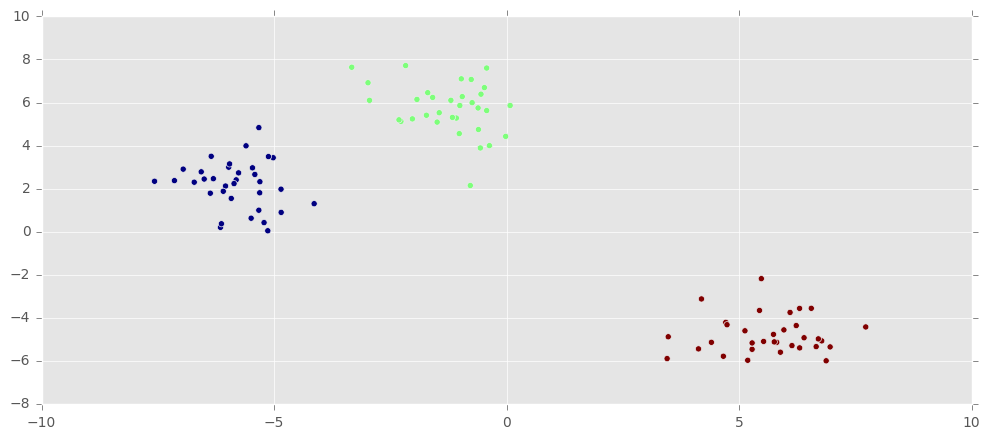

In [816]:
plt.scatter(X[:,0], X[:, 1], c=y)

#### Задание 2 (1 балл) 

Проверьте вашу имплементацию на простых данных

In [817]:
# Your Code Here
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
km = Kmeans(max_iter=100, k=3, random_state=42)
km.fit(X)
labels = km.predict(X)
print km.n_iters

3


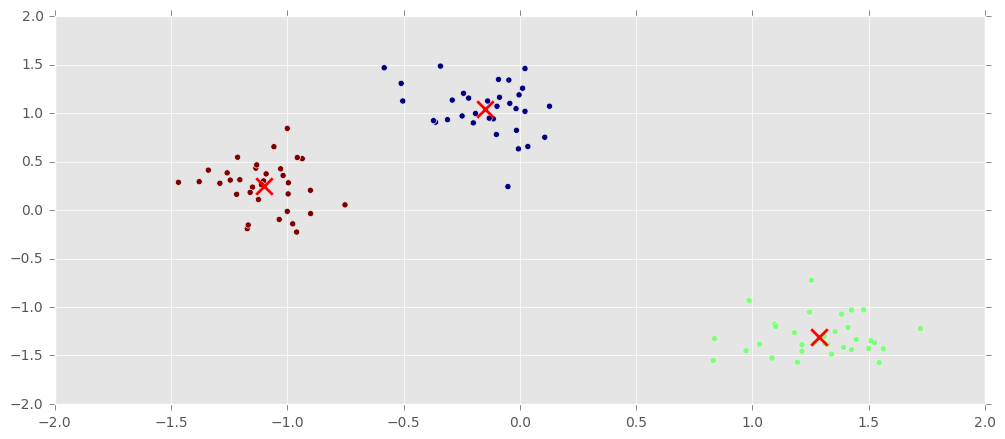

In [818]:
plt.scatter(X[:,0], X[:, 1], c=labels)
plt.scatter(km.centroids[:,0], km.centroids[:,1], c='red', marker='x', s=140, linewidths=2)

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.

In [819]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

#### Задание 3 (4 балла)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)

In [820]:
# delete all features except 36 keywords
df_sns_restricted = df_sns[df_sns.columns[4:]]
df_sns_restricted.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


In [821]:
# check if data has NaN-containing rows
df_sns_restricted.shape[0] - df_sns_restricted.dropna().shape[0]

0

In [822]:
for column in df_sns_restricted.columns:
    df_sns_restricted.loc[:,column] = (df_sns_restricted[column] - df_sns_restricted[column].mean())/\
    df_sns_restricted[column].var()
df_sns_restricted.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,-0.412835,-0.507107,-0.264788,-0.294609,-0.349509,-0.502846,-0.403092,-0.385504,-0.326787,-0.630717,...,-0.026224,-0.531663,-0.672712,-0.664761,-0.580983,-0.654713,-0.472027,-0.598737,-0.552206,-0.506205
1,-0.412835,1.502830,-0.264788,-0.294609,-0.349509,-0.502846,-0.403092,-0.385504,-0.326787,-0.630717,...,-0.026224,1.534117,-0.672712,-0.664761,-0.580983,-0.654713,-0.472027,-0.598737,-0.552206,-0.506205
2,-0.412835,1.502830,-0.264788,-0.294609,-0.349509,-0.502846,-0.403092,-0.385504,-0.326787,-0.630717,...,-0.026224,-0.531663,-0.672712,-0.664761,-0.580983,-0.654713,-0.472027,4.642616,-0.552206,-0.506205
3,-0.412835,-0.507107,-0.264788,-0.294609,-0.349509,-0.502846,-0.403092,-0.385504,-0.326787,-0.630717,...,-0.026224,-0.531663,-0.672712,-0.664761,-0.580983,-0.654713,-0.472027,-0.598737,-0.552206,-0.506205
4,-0.412835,-0.507107,-0.264788,-0.294609,-0.349509,-0.502846,-0.403092,-0.385504,-0.326787,-0.630717,...,-0.026224,-0.531663,3.138686,-0.664761,-0.580983,-0.654713,-0.472027,-0.598737,5.725238,7.870048


In [843]:
# found random states and non-empty clusters for them
# [0 1 2 3 5 6 7 8] 201949
# [0 1 2 3 4 5 7 8] 1515
km = Kmeans(k=9, max_iter=1000, random_state=201949)
km.fit(df_sns_restricted)

Kmeans(k=9, max_iter=1000, metric='euclidean', random_state=201949)

In [844]:
print km.n_iters

103


In [845]:
clustered_df = pd.concat([df_sns_restricted, pd.DataFrame(km.labels, columns=["cluster"])],axis=1) 
clustered_df.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs,cluster
0,-0.412835,-0.507107,-0.264788,-0.294609,-0.349509,-0.502846,-0.403092,-0.385504,-0.326787,-0.630717,...,-0.531663,-0.672712,-0.664761,-0.580983,-0.654713,-0.472027,-0.598737,-0.552206,-0.506205,0
1,-0.412835,1.502830,-0.264788,-0.294609,-0.349509,-0.502846,-0.403092,-0.385504,-0.326787,-0.630717,...,1.534117,-0.672712,-0.664761,-0.580983,-0.654713,-0.472027,-0.598737,-0.552206,-0.506205,0
2,-0.412835,1.502830,-0.264788,-0.294609,-0.349509,-0.502846,-0.403092,-0.385504,-0.326787,-0.630717,...,-0.531663,-0.672712,-0.664761,-0.580983,-0.654713,-0.472027,4.642616,-0.552206,-0.506205,0
3,-0.412835,-0.507107,-0.264788,-0.294609,-0.349509,-0.502846,-0.403092,-0.385504,-0.326787,-0.630717,...,-0.531663,-0.672712,-0.664761,-0.580983,-0.654713,-0.472027,-0.598737,-0.552206,-0.506205,0
4,-0.412835,-0.507107,-0.264788,-0.294609,-0.349509,-0.502846,-0.403092,-0.385504,-0.326787,-0.630717,...,-0.531663,3.138686,-0.664761,-0.580983,-0.654713,-0.472027,-0.598737,5.725238,7.870048,8


In [846]:
# watch clusters size
print clustered_df.groupby("cluster").size()

cluster
0    25014
1     1143
2        4
3        1
5     1202
6       98
7     1412
8     1126
dtype: int64


In [847]:
# interpret clusters
for c_idx in xrange(8):
    print "Cluster %d:\n" % c_idx
    print clustered_df.groupby("cluster").apply(lambda x: x.set_index("cluster").mean().nlargest(10))[c_idx]

Cluster 0:

blonde       -0.008326
soccer       -0.009945
baseball     -0.013042
volleyball   -0.014969
softball     -0.018796
basketball   -0.020872
tennis       -0.022522
dance        -0.027600
football     -0.030858
church       -0.033198
dtype: float64
Cluster 1:

marching    12.022366
bible        6.760535
band         1.716366
jesus        0.550470
church       0.368954
music        0.235207
god          0.234772
rock         0.202091
swimming     0.161639
clothes      0.153778
dtype: float64
Cluster 2:

bible       196.483803
jesus        25.526888
god          10.134205
church        1.799637
clothes       1.573492
swimming      1.367860
death         0.711601
hot           0.537503
die           0.168966
soccer        0.032370
dtype: float64
Cluster 3:

kissed      99.823813
drunk       30.835013
sex          7.756403
hair         4.626614
band         3.755268
rock         3.385109
music        3.355073
church       2.518438
mall         1.534117
shopping     1.232987
dtype: 

## Интерпретация найденных кластеров